In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(sctransform)
    library(data.table)
    library(SeuratDisk)
    library(ggplot2)
    library(cowplot)
    library(RhpcBLASctl)
    library(matrixStats)
})

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.0.5”


In [2]:
# data_path = "/media/lewislab/Dropbox\ \(UCSD\ SBRG\)//Dropbox\ \(UCSD\ SBRG\)/Collaborations/Norcross_Lab/"
data_path = '/data2/hratch/FDA_collab/'
results_path = '/data2/hratch/FDA_collab/'
seed = 1448145
set.seed(seed) # seurat default seed
n_cores = 20
RhpcBLASctl::blas_set_num_threads(n_cores)

In [2]:
Untreated_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', 'my061_3_untreated_freshlnwithdc_dereg/filtered_feature_bc_matrix/'))
ABC_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my060_4_Day4_ABC_mcm_057m/filtered_feature_bc_matrix/"))
DT_Veh_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my060_2_Day4_DT_Veh_mcm_057m/filtered_feature_bc_matrix/"))
DT_ABC_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my060_3_Day4_DT_ABC_mcm_057m/filtered_feature_bc_matrix/"))
aCD4_ABC_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my061_4_anticd4abc_d4_freshlnwithdc_dereg/filtered_feature_bc_matrix/"))


In [62]:
raw_data<-list('UNTR' = Untreated_data, 'ABC' = ABC_data, 'DT_Veh' = DT_Veh_data, 'DT_ABC' = DT_ABC_data, 
               'aCD4_ABC' = aCD4_ABC_data)
raw_objects<-lapply(names(raw_data), function(n) CreateSeuratObject(counts = raw_data[[n]], project = n, 
                                                                    min.cells = 3, min.features = 200))
names(raw_objects)<-names(raw_data)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



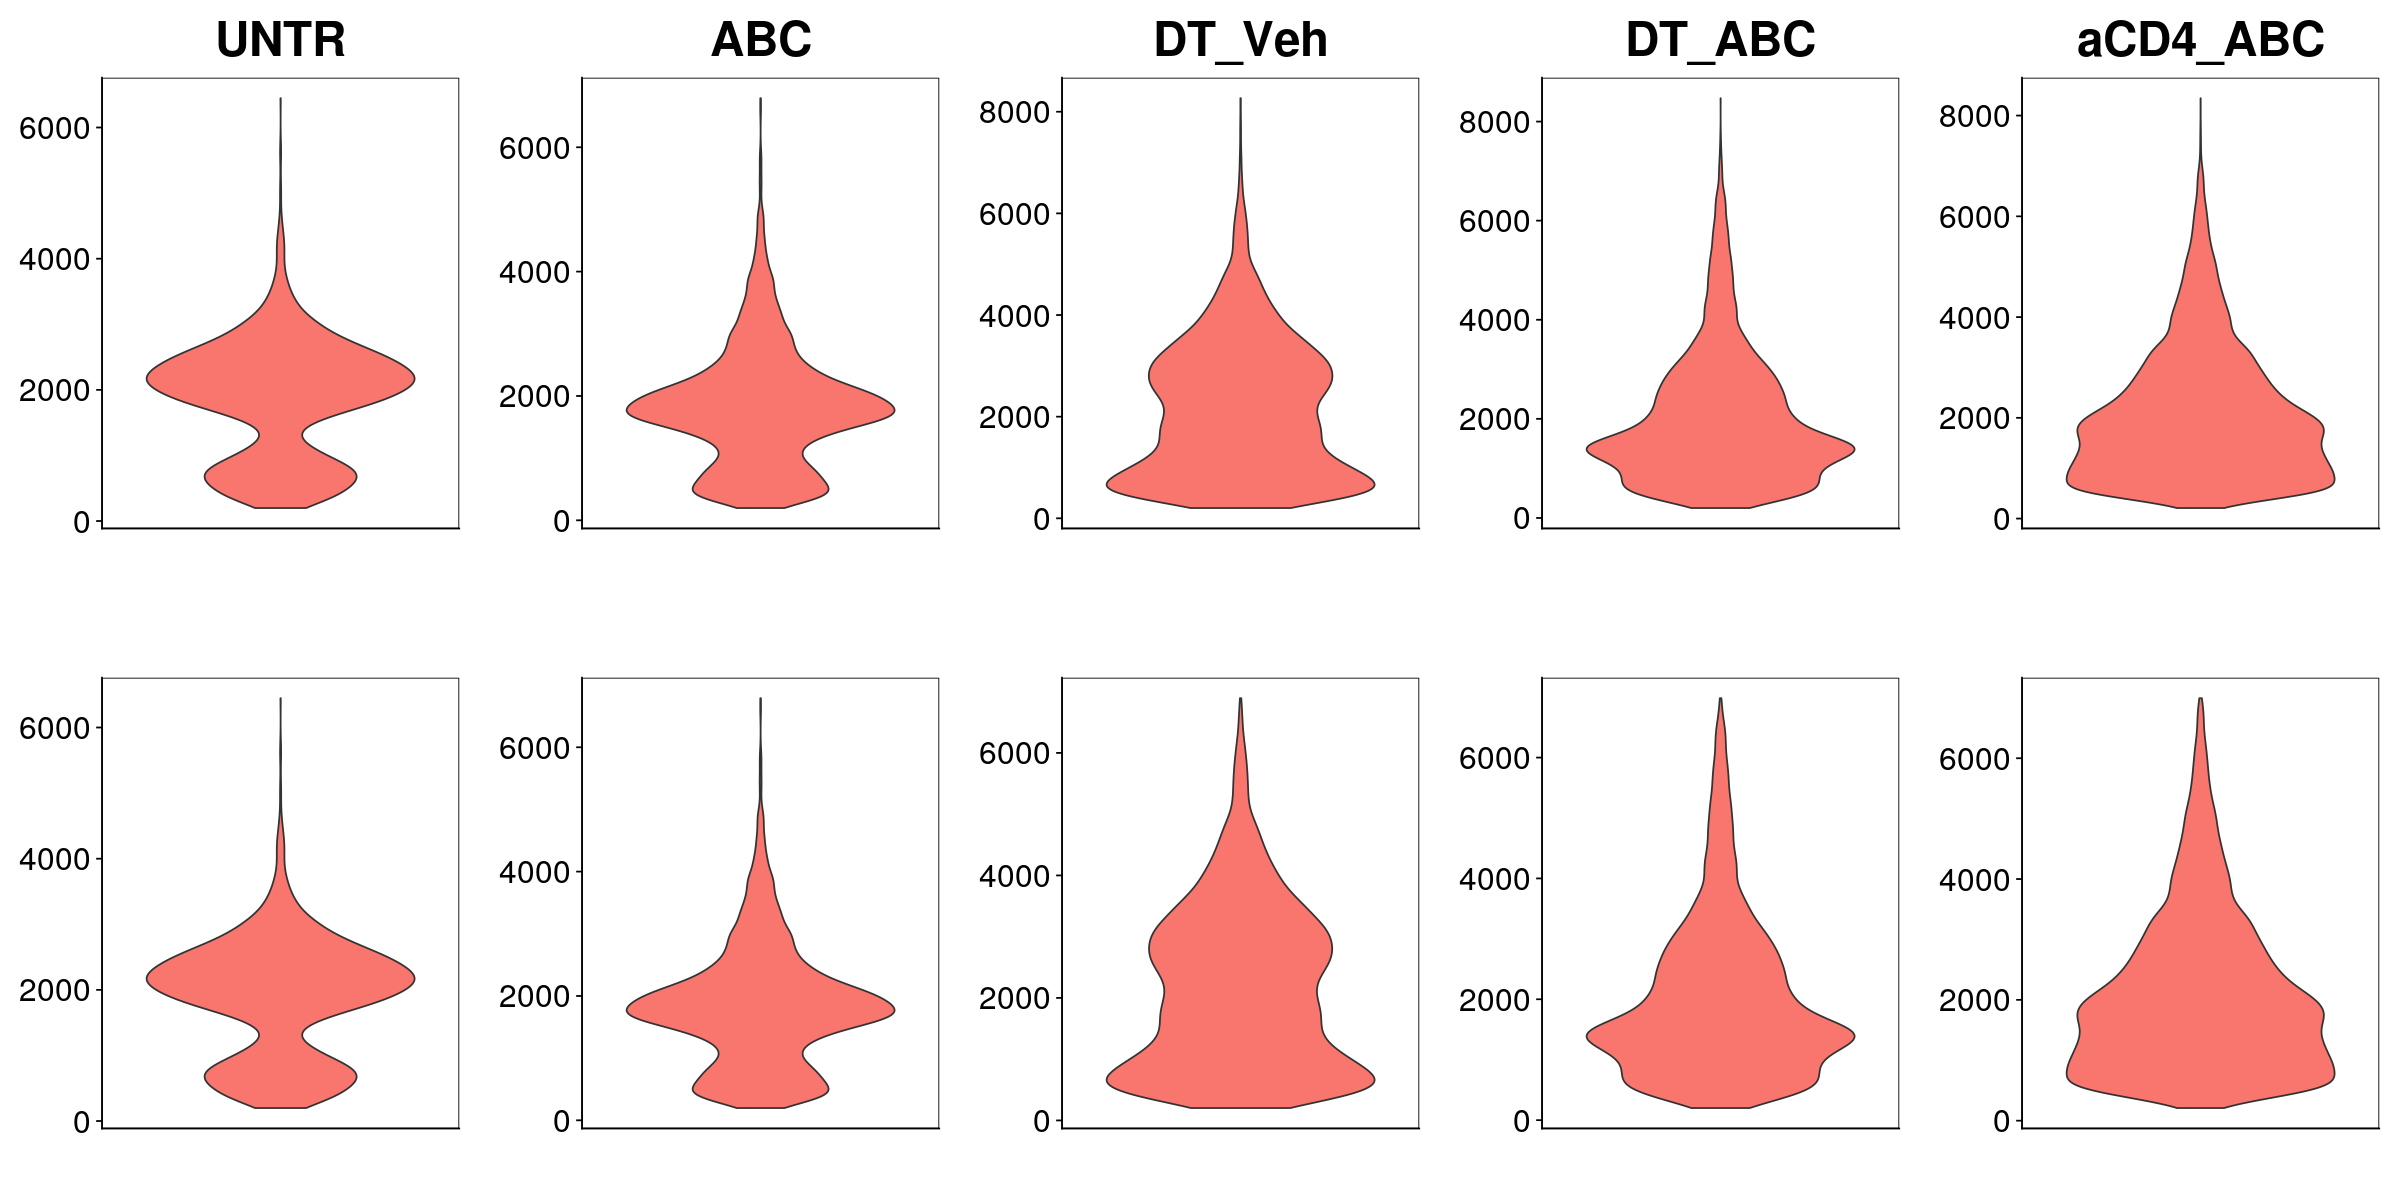

In [63]:
theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=25), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=25), legend.text=element_text(size=13), 
         legend.title=element_text(size=17), axis.text.x = element_text(size = 19), 
             axis.text.y = element_text(size = 19)) 
viz_features1<-function(n){
    g<-VlnPlot(raw_objects[[n]], features = c("nFeature_RNA"), pt.size = 0)+ggtitle(n) + theme(legend.position = "none") + 
    theme + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + labs(x = "")
    return(g)
}
viz_features2<-function(n){
    g<-VlnPlot(raw_objects[[n]], features = c("nFeature_RNA"), pt.size = 0)+ggtitle("") + theme(legend.position = "none") + 
    theme + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + labs(x = "")
    return(g)
}
n = names(raw_objects)[[1]]
viz_pre_filter = lapply(names(raw_objects), function(n) viz_features1(n))
raw_objects<-lapply(raw_objects, function(x) subset(x, subset = nFeature_RNA < 7000))
viz_post_filter = lapply(names(raw_objects), function(n) viz_features2(n))
                         
h_ = 10
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)
g1<-cowplot::plot_grid(viz_pre_filter[[1]], viz_pre_filter[[2]], viz_pre_filter[[3]], viz_pre_filter[[4]], viz_pre_filter[[5]],
             viz_post_filter[[1]], viz_post_filter[[2]], viz_post_filter[[3]], viz_post_filter[[4]], viz_post_filter[[5]],
             nrow = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(results_path, 'figures/', 'nfeatures_upperlim', ext), g1)}
g1

In [80]:
f1<-function(so){
    so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^mt-")
    return(so)
}
raw_objects<-lapply(raw_objects, f1)

In [87]:
suppressWarnings(transformed_objects<-lapply(raw_objects, function(x) 
                                             SCTransform(x, vars.to.regress = "percent.mt", method = "glmGamPoi", 
                                                         verbose = F, seed.use = seed)))

# Integrate Datasets

In [90]:
combined.features <- SelectIntegrationFeatures(object.list = transformed_objects, nfeatures = 3000)
combined.list <- PrepSCTIntegration(object.list = transformed_objects, anchor.features = combined.features)
combined.anchors <- FindIntegrationAnchors(object.list = combined.list, normalization.method = "SCT", 
                                           anchor.features = combined.features)
combined.integrated <- IntegrateData(anchorset = combined.anchors, normalization.method = "SCT")
DefaultAssay(combined.integrated) <- "integrated"

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8142 anchors

Filtering anchors

	Retained 7415 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7474 anchors

Filtering anchors

	Retained 5116 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8307 anchors

Filtering anchors

	Retained 7313 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10400 anchors

Filtering anchors

	Retained 7511 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 11394 anchors

Filtering anchors

	Retained 9370 anchors

Finding anchors

	Found 12426 anchors

Filtering anchors

	Retained 7596 anchors

Running CCA

Merging objects

Finding neighborho

In [4]:
##checkpoint
# saveRDS(combined.integrated, paste0(data_path, 'processed/combined.integrated.rds'))
# combined.integrated<-readRDS(paste0(data_path, 'processed/combined.integrated.rds'))

In [6]:
combined.integrated <- RunPCA(combined.integrated, verbose = F, npcs = 100, seed.use = seed)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



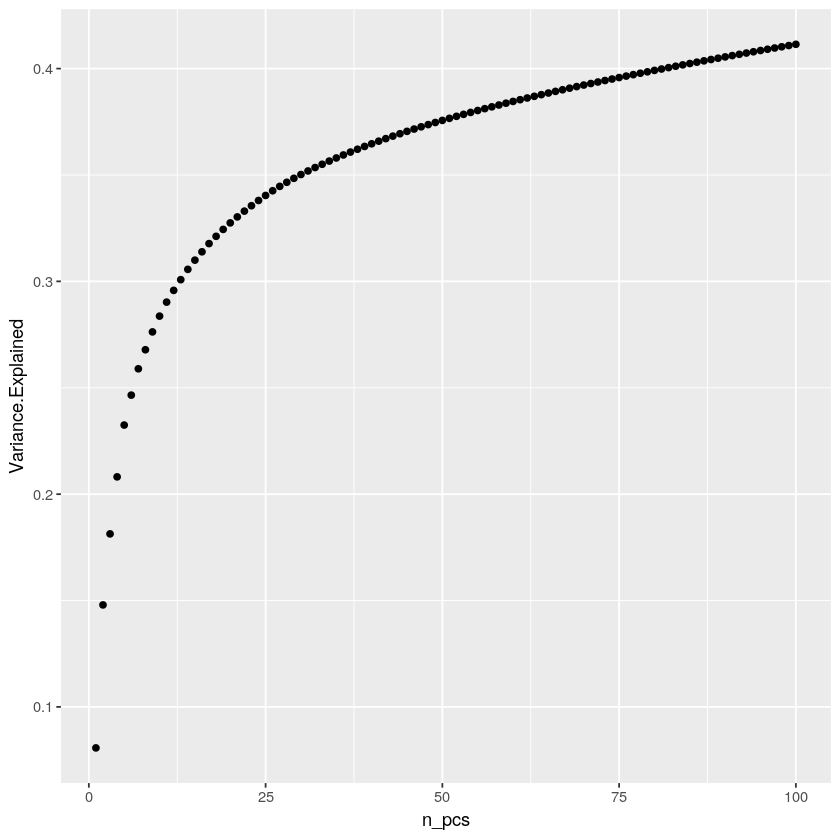

In [74]:
h_ = 6
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

total_variance <- sum(matrixStats::rowVars(combined.integrated@assays$integrated@scale.data))
eigValues = (combined.integrated@reductions$pca@stdev)^2
varExplained = eigValues / total_variance


viz_df = data.frame(varExplained)
viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

n_pcs = min(which(diff(viz_df$Variance.Explained) < 0.001)) # which PC is the additional variance explained < 0.01%
print(paste0('Additional variance explained is <0.01% at ', n_pcs, ' pcs')) # 48!
g2<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point()
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(results_path, 'figures/', 'variance_explained', ext), g2, 
                                             height = h_, width = w_)}
g2

In [80]:
combined.integrated <- FindNeighbors(combined.integrated, reduction = "pca", dims = 1:n_pcs)
combined.integrated <- FindClusters(combined.integrated, resolution = 0.5, random.seed = seed, method = 'igraph')
combined.integrated <- RunUMAP(combined.integrated, reduction = "pca", dims = 1:n_pcs, seed.use = seed)

Computing nearest neighbor graph

Computing SNN



Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


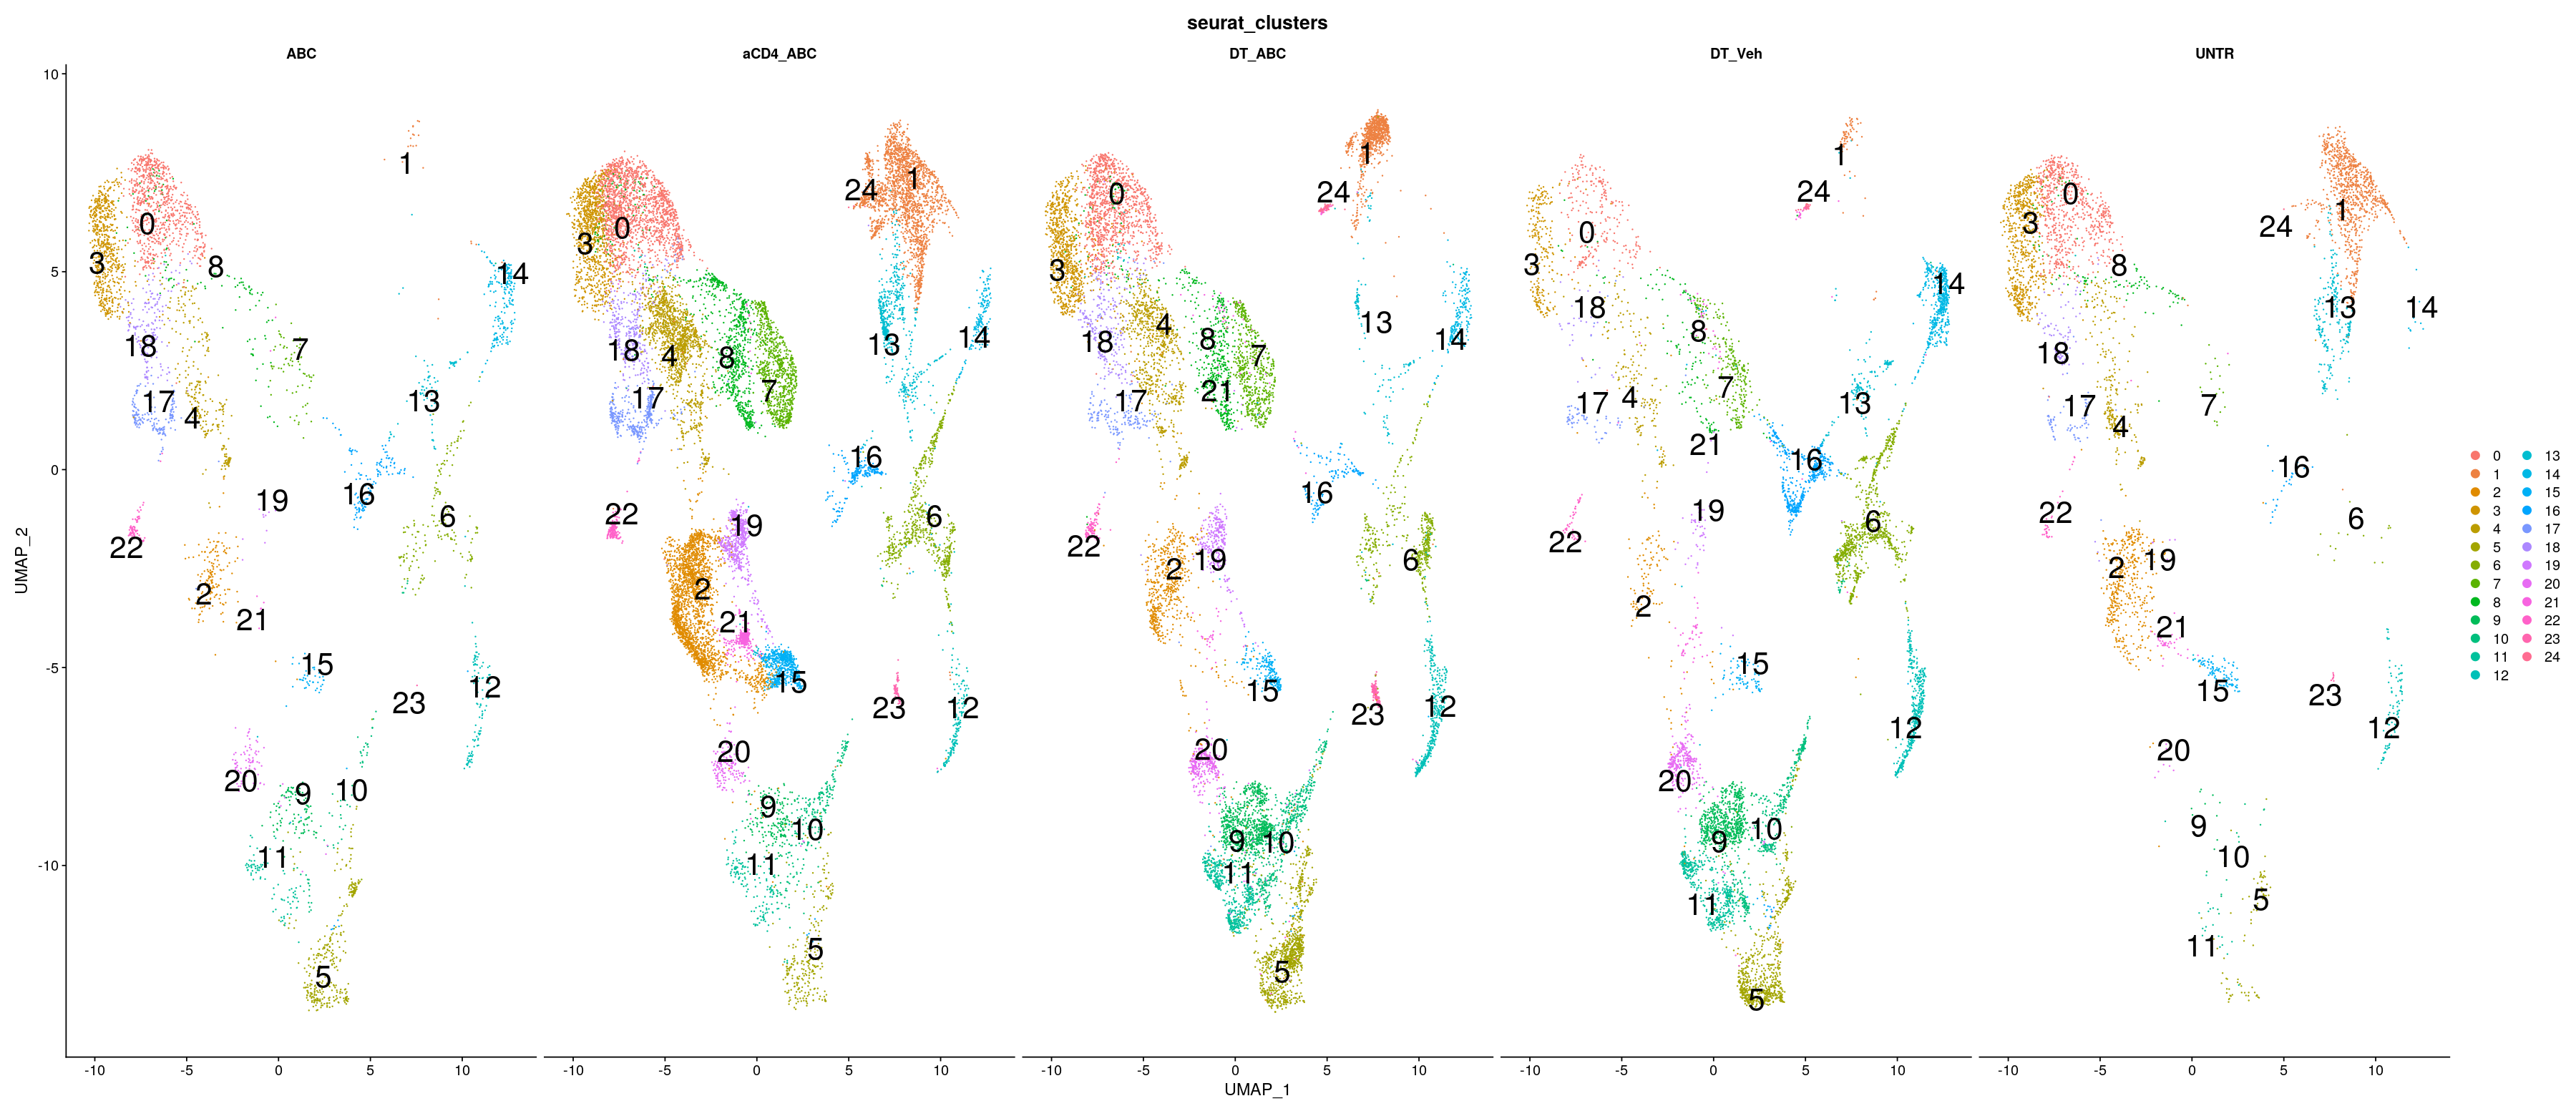

In [85]:
h_ = 13
w_ = 30
options(repr.plot.height=h_, repr.plot.width=w_)
suppressWarnings(g3 <- DimPlot(combined.integrated, reduction = "umap", split.by = "orig.ident", 
              group.by = "seurat_clusters", label=TRUE, repel=TRUE, label.size = 9))
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(results_path, 'figures/', 'umap_by_treatment', ext), g3)}
g3

In [84]:
# note that seeds did not work from Marco's script version (likely due to differen OS)

saveRDS(combined.integrated, paste0(results_path, 'interim/combined_integrated_prelabel.rds'))
# fwrite(combined.integrated@assays$integrated@scale.data, 
#        paste0(results_path, 'processed/', 'integrated_counts.csv'))
# # save raw counts for cci analysis
# # SaveH5Seurat(combined.integrated, filename = paste0(results_path, 'processed/', "combined.h5Seurat"))
# # Convert(paste0(results_path, 'processed/', "combined.h5Seurat"), dest = "h5ad")
# DefaultAssay(combined.integrated) <- "RNA"
# SaveH5Seurat(combined.integrated, filename = paste0(results_path, 'processed/', "raw_counts.h5Seurat"))
# Convert(paste0(results_path, 'processed/', "raw_counts.h5Seurat"), dest = "h5ad")
# DefaultAssay(combined.integrated) <- "integrated"

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding data from RNA as X

Adding counts from RNA as raw

Transfering meta.data to obs

Adding dimensional reduction information fo

In [55]:
# # manually map cell types
# md<-combined.integrated@meta.data

# clust<-sort(unique(combined.integrated@meta.data$seurat_clusters))
# clust<-as.character(clust)
# ct<-rep(list(NULL), length(clust))
# names(ct)<-clust
# ct[['2']]<-'b_cell'
# ct[['1']]<-'cd8_t'
# ct[['9']]<-'cd8_t'
# ct[['12']]<-'nk_nkt'
# ct[['3']]<-'cd4_t'
# ct[['0']]<-'cd8_t'
# ct[['15']]<-'cd8_t'
# ct[['5']]<-'cd8t_pd1'
# ct[['8']]<-'cd8t_pd1'
# ct[['10']]<-'cd8t_pd1'
# ct[['16']]<-'xcr1_dc'
# ct[['6']]<-'dc'
# ct[['17']]<-'dc'
# ct[['4']]<-'dc'
# ct[['18']]<-'dc'
# ct[['14']]<-'pdc'
# md[['cell_type']]<-unname(ct[as.character(md$seurat_clusters)])
# md$cell_type <- vapply(md$cell_type, paste, collapse = ", ", character(1L))
# write.csv(md, paste0(data_path, 'processed/metadata.csv'))